In [116]:
import os
import re
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, List, Tuple
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

In [117]:
DATA_PATH = "/content/loan_approval_dataset (1).csv"

In [118]:
TARGET_COL: Optional[str] = None

In [119]:
OUTPUT_DIR = "loan_project_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [120]:
def detect_feature_types(df: pd.DataFrame) -> Tuple[List[str], List[str]]:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    return num_cols, cat_cols

def guess_target_column(df: pd.DataFrame) -> Optional[str]:
    """Heuristic: try common names, else a small-cardinality column near the end."""
    name_candidates = [
        "loan_status","loanstatus","status","approval_status","approved","is_approved",
        "loan_approval_status","loan_approved","decision","target","label","outcome",
        "result","class","Loan_Status","LoanStatus","Approval_Status","Approved"
    ]
    lower_map = {c.lower(): c for c in df.columns}
    for nm in name_candidates:
        if nm in lower_map:
            return lower_map[nm]
    cand = []
    for c in df.columns:
        if re.search(r"id$|^id$|^index$|^serial|^sr_no|^sno|^no$", c, re.I):
            continue
        nun = df[c].nunique(dropna=True)
        if 2 <= nun <= 10:
            cand.append(c)
    if cand:
        return cand[-1]
    last = df.columns[-1]
    if df[last].nunique(dropna=True) <= 10:
        return last
    return None

def safe_plot_save(fig_path: str):
    plt.tight_layout()
    plt.savefig(fig_path, dpi=150)
    plt.close()

In [121]:
print("Loading dataset from:", DATA_PATH)
df = pd.read_csv(DATA_PATH, encoding="utf-8", engine="python")
print("Shape:", df.shape)
print("Columns:", list(df.columns))

# Show basic missing values overview
missing = df.isna().sum().sort_values(ascending=False).to_frame("missing_count")
missing["missing_pct"] = (missing["missing_count"] / len(df) * 100).round(2)
missing.to_csv(os.path.join(OUTPUT_DIR, "missing_values_summary.csv"))

Loading dataset from: /content/loan_approval_dataset (1).csv
Shape: (4269, 13)
Columns: ['loan_id', ' no_of_dependents', ' education', ' self_employed', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value', ' loan_status']


In [122]:
num_cols, cat_cols = detect_feature_types(df)

In [123]:
for col in num_cols[:6]:
    plt.figure()
    df[col].dropna().plot(kind="hist", bins=30, title=f"Histogram: {col}")
    plt.xlabel(col); plt.ylabel("Frequency")
    safe_plot_save(os.path.join(OUTPUT_DIR, f"hist_{col}.png"))

In [124]:
for col in cat_cols[:6]:
    plt.figure()
    df[col].astype(str).value_counts(dropna=False).head(20).plot(
        kind="bar", title=f"Top categories: {col}"
    )
    plt.xlabel(col); plt.ylabel("Count")
    safe_plot_save(os.path.join(OUTPUT_DIR, f"bar_{col}.png"))

In [125]:
if num_cols:
    corr = df[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(6,5))
    plt.imshow(corr, interpolation="nearest")
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.colorbar()
    safe_plot_save(os.path.join(OUTPUT_DIR, "correlation_heatmap.png"))

In [126]:
# Detect/confirm target
target = TARGET_COL if TARGET_COL else guess_target_column(df)
print("Detected target column:", target)

if target is not None:
    plt.figure()
    df[target].value_counts(dropna=False).plot(kind="bar", title=f"Target Distribution: {target}")
    plt.xlabel(target); plt.ylabel("Count")
    safe_plot_save(os.path.join(OUTPUT_DIR, "target_distribution.png"))
else:
    # If not found, suggest likely candidates
    small_card = [c for c in df.columns if 2 <= df[c].nunique(dropna=True) <= 10]
    print("⚠ No clear target found. Set TARGET_COL manually.")
    print("Small-cardinality candidates (2..10 unique):", small_card)
    # Exit early so you can set TARGET_COL
    raise SystemExit(0)



Detected target column:  loan_status


In [127]:
# -------- Step 3) Preprocessing (numeric + categorical) --------
df_model = df.dropna(subset=[target]).copy()
X = df_model.drop(columns=[target])
y = df_model[target]

num_cols_X = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_X = X.select_dtypes(include=["object","category","bool"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols_X),
    ("cat", categorical_transformer, cat_cols_X),
])


# -------- Step 4) Train/Test Split --------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
classes = np.unique(y_train)
is_binary = len(classes) == 2

In [128]:
# -------- Step 5) Define Models --------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42)
}


# -------- Step 6) Train + Evaluate --------
def evaluate_model(name: str, pipe: Pipeline) -> dict:
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    row = {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision_macro": precision_score(y_test, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_test, y_pred, average="macro", zero_division=0),
        "f1_macro": f1_score(y_test, y_pred, average="macro", zero_division=0),
        "roc_auc_ovr": np.nan
    }

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix: {name}")
    plt.xticks(range(len(classes)), classes, rotation=45, ha="right")
    plt.yticks(range(len(classes)), classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.ylabel("True label"); plt.xlabel("Predicted label")
    safe_plot_save(os.path.join(OUTPUT_DIR, f"cm_{name.replace(' ', '_').lower()}.png"))

    # ROC curve (binary only + needs predict_proba)
    if is_binary and hasattr(pipe, "predict_proba"):
        try:
            proba = pipe.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, proba)
            plt.figure()
            RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
            plt.title(f"ROC Curve: {name}")
            safe_plot_save(os.path.join(OUTPUT_DIR, f"roc_{name.replace(' ', '_').lower()}.png"))
        except Exception:
            pass

    # ROC-AUC OvR (binary or multi-class)
    if hasattr(pipe, "predict_proba"):
        try:
            prob = pipe.predict_proba(X_test)
            if is_binary:
                idx = 1 if prob.shape[1] > 1 else 0
                row["roc_auc_ovr"] = roc_auc_score(y_test, prob[:, idx])
            else:
                row["roc_auc_ovr"] = roc_auc_score(y_test, prob, multi_class="ovr")
        except Exception:
            pass


    return row, pipe

In [129]:
metrics = []
best_row = None
best_pipe = None

for name, model in models.items():
    pipeline = Pipeline(steps=[("preprocess", preprocessor), ("model", model)])
    row, trained_pipe = evaluate_model(name, pipeline)
    metrics.append(row)

    if (best_row is None) or (row["f1_macro"] > best_row["f1_macro"]):
        best_row = row
        best_pipe = trained_pipe

results = pd.DataFrame(metrics)
print(results)

                  model  accuracy  precision_macro  recall_macro  f1_macro  \
0   Logistic Regression  0.921546         0.920246      0.912050  0.915805   
1         Random Forest  0.981265         0.981250      0.978870  0.980034   
2  HistGradientBoosting  0.984778         0.986630      0.981089  0.983727   

   roc_auc_ovr  
0     0.974334  
1     0.998143  
2     0.999125  


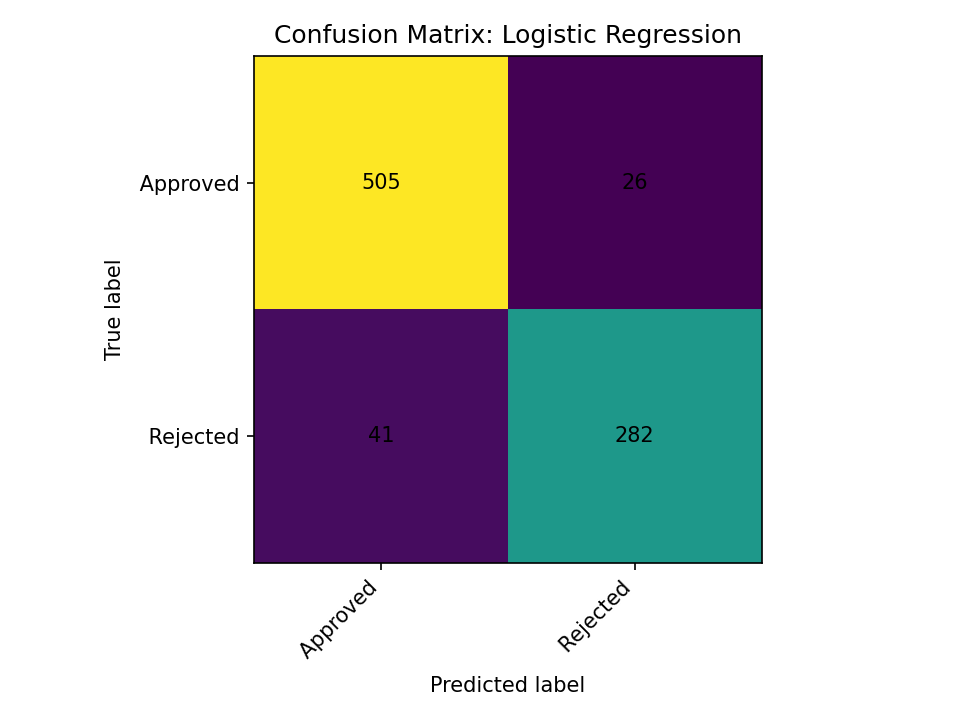

In [133]:
import os
from IPython.display import Image

# Show one saved image
Image(filename=os.path.join(OUTPUT_DIR, "cm_logistic_regression.png"))

In [136]:
from google.colab import output
import IPython.display as display
import pandas as pd


In [137]:
# Example prediction function
def predict_loan(data):
    input_df = pd.DataFrame([data])
    pred = best_pipe.predict(input_df)[0]
    return "✅ Loan Approved" if pred == 1 else "❌ Loan Rejected"


In [138]:
html_code = """
<h2>Loan Approval Prediction</h2>
<form id="loanForm">
  Gender:
  <select id="Gender">
    <option value="Male">Male</option>
    <option value="Female">Female</option>
  </select><br><br>

  Married:
  <select id="Married">
    <option value="Yes">Yes</option>
    <option value="No">No</option>
  </select><br><br>

  Applicant Income: <input type="number" id="ApplicantIncome"><br><br>
  Loan Amount: <input type="number" id="LoanAmount"><br><br>
  Credit History:
  <select id="Credit_History">
    <option value="1">1</option>
    <option value="0">0</option>
  </select><br><br>

  <button type="button" onclick="makePrediction()">Predict</button>
</form>

<h3>Result: <span id="result"></span></h3>

<script>
  async function makePrediction() {
    let data = {
      "Gender": document.getElementById("Gender").value,
      "Married": document.getElementById("Married").value,
      "ApplicantIncome": parseFloat(document.getElementById("ApplicantIncome").value),
      "LoanAmount": parseFloat(document.getElementById("LoanAmount").value),
      "Credit_History": parseInt(document.getElementById("Credit_History").value)
    };
    let result = await google.colab.kernel.invokeFunction('notebook.predictLoan', [data], {});
    document.getElementById("result").innerText = result.data['text/plain'];
  }
</script>
"""
display.HTML(html_code)


In [140]:
def predictLoan(data):
    return predict_loan(data)

output.register_callback('notebook.predictLoan', predictLoan)
